<a href="https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/parallelPFPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding periodic-frequent patterns in big temporal databases using Parallel PFP-growth

This tutorial has two parts. In the first part, we describe the basic approach to find periodic-frequent patterns in a temporal database using the parallel PFP-growth algorithm. In the final part, we describe an advanced approach, where we evaluate the algorithm on a dataset at different *minimum support* threshold values using multiple cores (or worker machines).

***

## Prerequisites:

1. Installing the PAMI library

In [11]:
!pip install -U 'pami[spark]' #install the pami repository

2. Downloading a sample dataset

In [12]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample transactional database

File ‘Temporal_T10I4D100K.csv’ already there; not retrieving.



3. Printing few lines of a dataset to know its format.

In [13]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


_format:_ every row contains a timestamp followed by a set of items seperated by a seperator.

__Example:__

timestamp1 item1 item2 item3 item4

timestamp2 item1 item4 item6

***

## Part 1: Finding periodic-frequent patterns using parallel PFP-growth

### Step 1: Understanding the statistics of a database to choose an appropriate *minimum support* (*minSup*) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.temporalDatabaseStats as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.temporalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj. getVarianceTransactionLength()}')
print(f'Minimum period : {obj.getMinimumPeriod()}')
print(f'Average period : {obj.getAveragePeriod()}')
print(f'Maximum period : {obj.getMaximumPeriod()}')

itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
numberOfTransactionPerTimeStamp = obj.getNumberOfTransactionsPerTimestamp()
obj.save(itemFrequencies,'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')
obj.save(numberOfTransactionPerTimeStamp, 'numberOfTransaction.csv')

#Alternative apporach to derive the database statistics and plot the graphs
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232
Minimum period : 1
Average period : 1.0
Maximum period : 1


### Step 2: Draw the items' frequency graph and transaction length's distribution graphs for more information

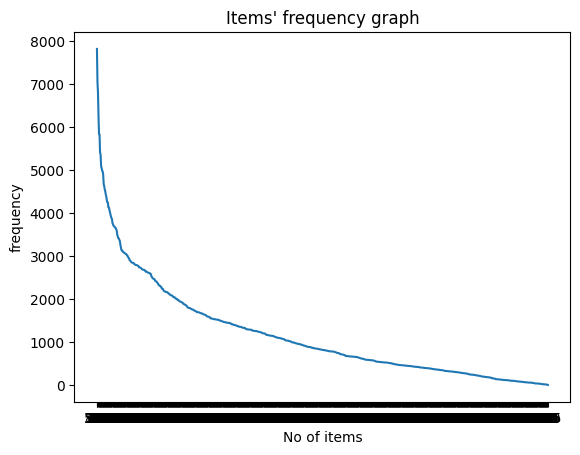

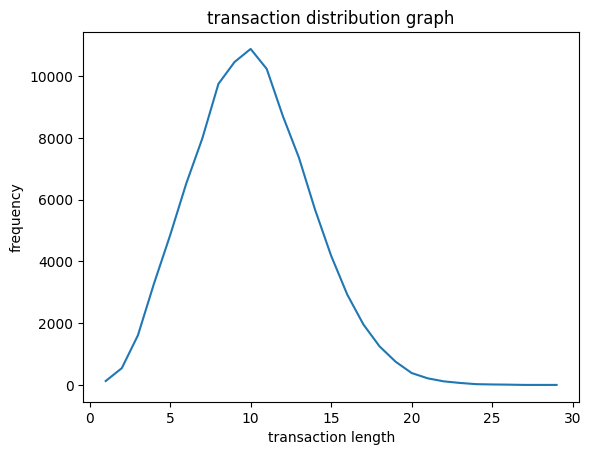

In [6]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

plt.plotLineGraphFromDictionary(itemFrequencies, 100, 'Items\' frequency graph', 'No of items', 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, 100, 'transaction distribution graph', 'transaction length', 'frequency')

### Step 3: Choosing an appropriate *minSup* and *maxPer* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 300 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.


  Similarly, let us choose a _maxPer_ value of 5000. That is, every periodic-frequent pattern must appear at least once in every 5000 transactions.

In [16]:
minSupValue=300 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
maxPerValue=5000

### Step 4: Choosing the number of worker machines

Let us choose the number of worker machines equal to 2

In [15]:
noWorkerMachines=2

### Step 5: Mining frequent patterns using parallel FP-growth

In [17]:
from PAMI.periodicFrequentPattern.basic import parallelPFPGrowth as alg  #import the algorithm

obj = alg.parallelPFPGrowth(iFile=inputFile, minSup=minSupValue, maxPer=maxPerValue, numWorkers=noWorkerMachines, sep='\t')    #initialize
obj.startMine()            #start the mining process

obj.save('periodicFrequentPatterns300_5000.txt') #save the patterns


patternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(patternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

ModuleNotFoundError: ignored

### Step 6: Investigating the generated patterns

Open the patterns' file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [ ]:
!head periodicFrequentPatterns300_5000.txt

368:7821 
529:7053 
829:6802 
766:6259 
722:5839 
354:5830 
684:5404 
217:5369 
494:5097 
419:5051 


The storage format is: _periodicFrequentPattern:support:periodicity_



***

## Part 2: Evaluating the FP-growth algorithm on a dataset at different minSup values and worker machines

### Step 1: Import the libraries and specify the input parameters

In [ ]:
#Import the libraries
from PAMI.frequentPattern.basic import FPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

numWorkers = [1,2, 3, 4, 5, 6, 7, 8, 9, 10]

### Step 2: Create a data frame to store the results of FP-growth

In [ ]:
result = pd.DataFrame(columns=['#workerMachines', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of FPGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [ ]:
from PAMI.frequentPattern.pyspark import parallelFPGrowth as alg

for minSupCount in minimumSupportCountList:
  for workers in numWorkers:
    obj = alg.parallelFPGrowth(iFile=inputFile, minSup=minSup, numWorkers=workers, sep='\t')    #initialize
    obj.startMine()            #start the mining process
    result.loc[result.shape[0]] = [workers, minSupCount, len(obj.getPatterns()),obj.getRuntime(), obj.getMemoryRSS()]

Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated successfully using Parallel FPGrowth algorithm
Frequent patterns were generated success

### Step 4: Print the result

In [ ]:
print(result)

    #workerMachines  minSup  patterns    runtime       memory
0               1.0   100.0    4540.0  24.150808  172367872.0
1               2.0   100.0    4540.0  23.102421  172830720.0
2               3.0   100.0    4540.0  26.334140  173113344.0
3               4.0   100.0    4540.0  26.972822  173113344.0
4               5.0   100.0    4540.0  29.442641  173244416.0
5               6.0   100.0    4540.0  29.658798  173244416.0
6               7.0   100.0    4540.0  32.552161  173244416.0
7               8.0   100.0    4540.0  31.103544  173244416.0
8               9.0   100.0    4540.0  34.204337  173244416.0
9              10.0   100.0    4540.0  35.184973  173244416.0
10              1.0   150.0    4540.0  25.804278  173244416.0
11              2.0   150.0    4540.0  23.459938  173260800.0
12              3.0   150.0    4540.0  27.136907  173260800.0
13              4.0   150.0    4540.0  28.673605  173260800.0
14              5.0   150.0    4540.0  30.165358  173260800.0
15      

### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

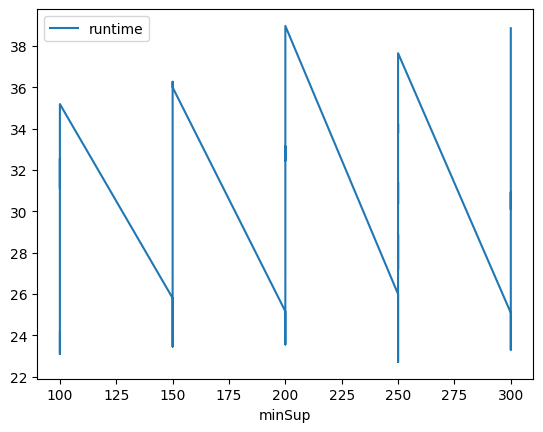

In [ ]:
result.plot(x='minSup',y='runtime')

In [ ]:
from PAMI.extras.graph import dataFrameInToFigures as dif
ab = dif.dataFrameInToFigures(result)
ab.plotGraphsFromDataFrame()

ValueError: ignored